# Time-series analysis of retail sales

## 1. Introduction

You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

## 2. Exploratory data analysis

Let's load some packages and the dataset.

In [1]:
import warnings
warnings.filterwarnings("ignore")

# loading packages
# basic + dates 
import numpy as np
import pandas as pd
from pandas import datetime

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns # advanced vizs
%matplotlib inline

# statistics
from statsmodels.distributions.empirical_distribution import ECDF

# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
# importing train data to learn
train = pd.read_csv(r'C:\Users\Igor\rossmann\train.csv', 
                    parse_dates = True, low_memory = False, index_col = 'Date')

# additional store data
store = pd.read_csv(r'C:\Users\Igor\rossmann\store.csv', 
                    low_memory = False)
# time series as indexes
train.index

DatetimeIndex(['2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31',
               ...
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01'],
              dtype='datetime64[ns]', name='Date', length=1017209, freq=None)

In [3]:
# first glance at the train set: head and tail
print(print("The dataframe has {} rows and {} columns".format(train.shape[0], train.shape[1])))
train.head(5)

The dataframe has 1017209 rows and 8 columns
None


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


In [3]:
# data extraction
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.weekofyear

# adding new variable
train['SalePerCustomer'] = train['Sales']/train['Customers']
train['SalePerCustomer'].describe()

count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: SalePerCustomer, dtype: float64

In [4]:
print("Closed stores and days which didn't have any sales won't be counted into the forecasts.")
train = train[(train["Open"] != 0) & (train['Sales'] != 0)]

print("In total: ", train.shape)

Closed stores and days which didn't have any sales won't be counted into the forecasts.
In total:  (844338, 13)


In [14]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [5]:
# missing values?
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [6]:
# missing values in CompetitionDistance
store[pd.isnull(store.CompetitionDistance)]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [7]:
# fill NaN with a median value (skewed distribuion)
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace = True)

In [8]:
# no promo = no information about the promo?
_ = store[pd.isnull(store.Promo2SinceWeek)]
_[_.Promo2 != 0].shape

(0, 10)

In [9]:
# replace NA's by 0
store.fillna(0, inplace = True)

In [10]:
print("Joining train set with an additional store information.")

# by specifying inner join we make sure that only those observations 
# that are present in both train and store sets are merged together
train_store = pd.merge(train, store, how = 'inner', on = 'Store')

print("In total: ", train_store.shape)
train_store.head()

Joining train set with an additional store information.
In total:  (844338, 22)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,SalePerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015,7,...,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,5020,546,1,1,0,1,2015,7,...,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,4782,523,1,1,0,1,2015,7,...,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,5011,560,1,1,0,1,2015,7,...,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,6102,612,1,1,0,1,2015,7,...,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


## 3. Transform the dataset to stationary

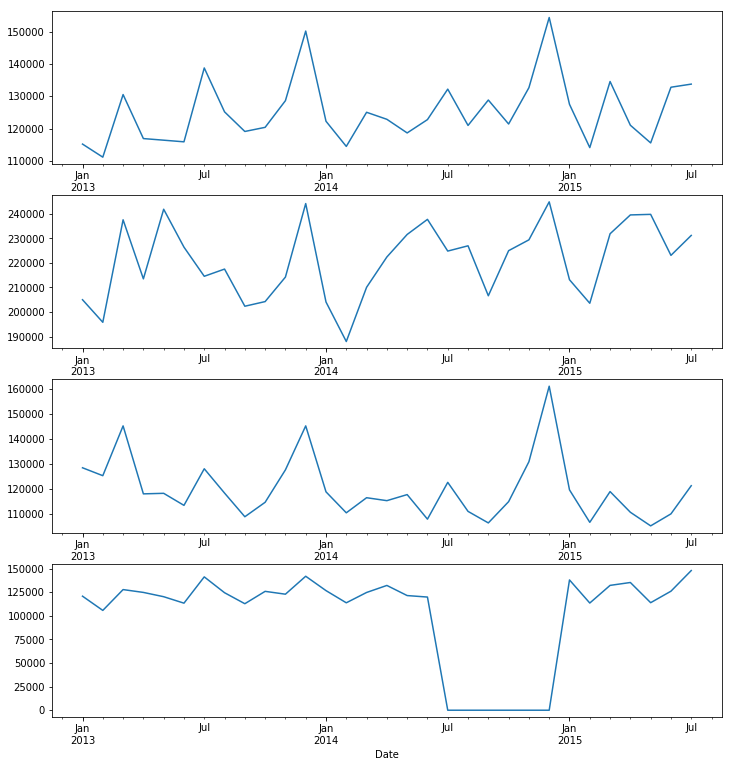

In [18]:
# preparation: input should be float type
train['Sales'] = train['Sales'].astype(float)

# store types
sales_a = train[train.Store == 2]['Sales']
sales_b = train[train.Store == 85]['Sales'].sort_index(ascending = True) # solve the reverse order
sales_c = train[train.Store == 1]['Sales']
sales_d = train[train.Store == 13]['Sales']

sales_a = sales_a.resample('M').sum()
sales_b = sales_b.resample('M').sum()
sales_c = sales_c.resample('M').sum()
sales_d = sales_d.resample('M').sum()

f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

# store types
sales_a.plot(ax = ax1)
sales_b.plot(ax = ax2)
sales_c.plot(ax = ax3)
sales_d.plot(ax = ax4)

### 3.1 Decomposition

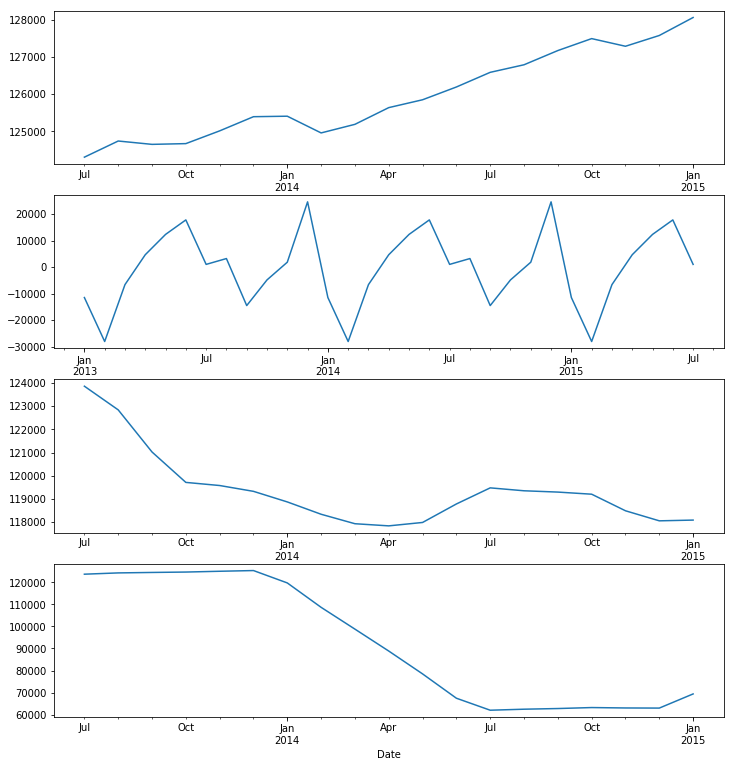

In [14]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

# monthly
decomposition_a = seasonal_decompose(sales_a, model = 'additive', freq = 12)
decomposition_a.trend.plot(ax = ax1)

decomposition_b = seasonal_decompose(sales_b, model = 'additive', freq = 12)
decomposition_b.trend.plot(ax = ax2)

decomposition_c = seasonal_decompose(sales_c, model = 'additive', freq = 12)
decomposition_c.trend.plot(ax = ax3)

decomposition_d = seasonal_decompose(sales_d, model = 'additive', freq = 12)
decomposition_d.trend.plot(ax = ax4)

### 3.2 Moving average

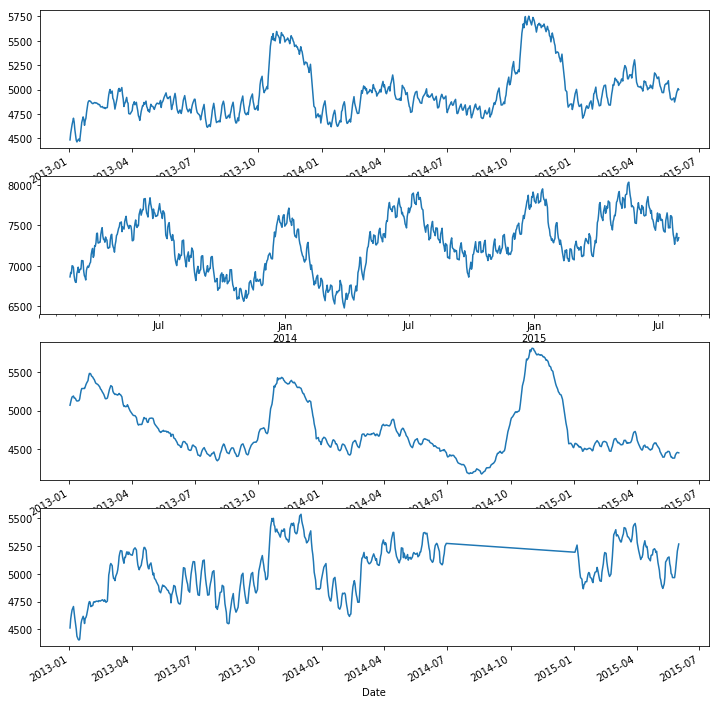

In [27]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

sales_a.rolling(52).mean().plot(ax = ax1)

sales_b.rolling(52).mean().plot(ax = ax2)

sales_c.rolling(52).mean().plot(ax = ax3)

sales_d.rolling(52).mean().plot(ax = ax4)



### 3.3 Differencing

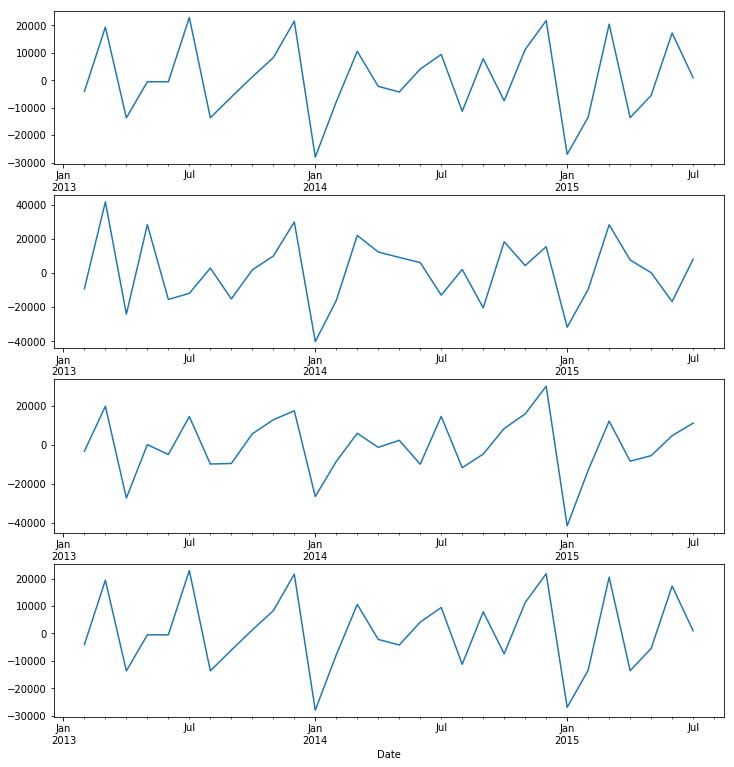

In [19]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

diff_sales_a = sales_a.diff()
diff_sales_a.plot(ax = ax1)

diff_sales_b = sales_b.diff()
diff_sales_b.plot(ax = ax2)

diff_sales_c = sales_c.diff()
diff_sales_c.plot(ax = ax3)

diff_sales_d = sales_a.diff()
diff_sales_d.plot(ax = ax4)

In [20]:
print(sales_a.head(5))
diff_sales_a = diff_sales_a.dropna(inplace = False)

Date
2013-01-31    115171.0
2013-02-28    111114.0
2013-03-31    130525.0
2013-04-30    116878.0
2013-05-31    116379.0
Freq: M, Name: Sales, dtype: float64


In [21]:
print(diff_sales_a)

Date
2013-02-28    -4057.0
2013-03-31    19411.0
2013-04-30   -13647.0
2013-05-31     -499.0
2013-06-30     -508.0
2013-07-31    22907.0
2013-08-31   -13615.0
2013-09-30    -6082.0
2013-10-31     1281.0
2013-11-30     8266.0
2013-12-31    21586.0
2014-01-31   -27965.0
2014-02-28    -7800.0
2014-03-31    10582.0
2014-04-30    -2178.0
2014-05-31    -4224.0
2014-06-30     4129.0
2014-07-31     9451.0
2014-08-31   -11257.0
2014-09-30     7876.0
2014-10-31    -7431.0
2014-11-30    11260.0
2014-12-31    21763.0
2015-01-31   -26922.0
2015-02-28   -13420.0
2015-03-31    20496.0
2015-04-30   -13562.0
2015-05-31    -5477.0
2015-06-30    17265.0
2015-07-31      965.0
Freq: M, Name: Sales, dtype: float64


In [52]:
from statsmodels.tsa.stattools import adfuller
#X = series.values
result = adfuller(diff_sales_a)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -12.199636
p-value: 0.000000


## 4. ACF and PACF to find the optimal parameters for the model

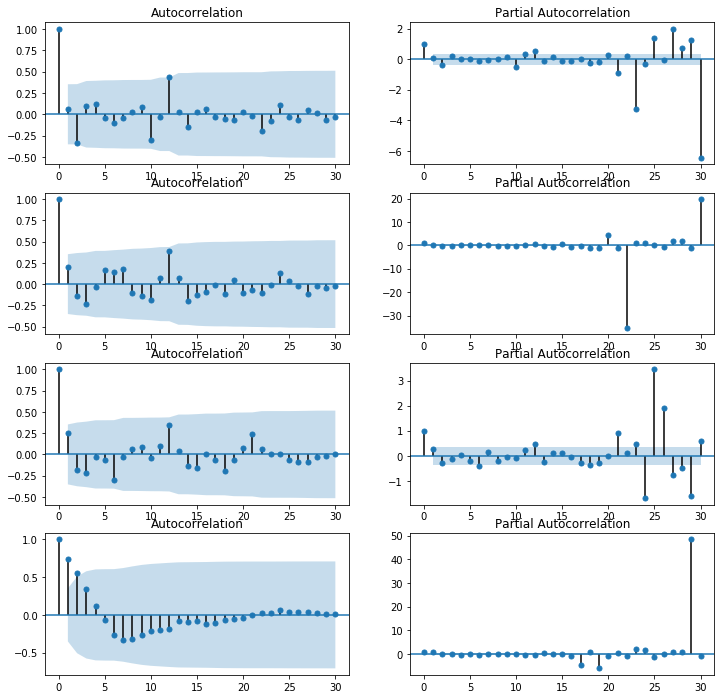

In [28]:
# figure for subplots
plt.figure(figsize = (12, 12))

# acf and pacf for A
plt.subplot(421); plot_acf(sales_a, lags = 30, ax = plt.gca())
plt.subplot(422); plot_pacf(sales_a, lags = 30, ax = plt.gca())

# acf and pacf for B
plt.subplot(423); plot_acf(sales_b, lags = 30, ax = plt.gca())
plt.subplot(424); plot_pacf(sales_b, lags = 30, ax = plt.gca())

# acf and pacf for C
plt.subplot(425); plot_acf(sales_c, lags = 30, ax = plt.gca())
plt.subplot(426); plot_pacf(sales_c, lags = 30, ax = plt.gca())

# acf and pacf for D
plt.subplot(427); plot_acf(sales_d, lags = 30, ax = plt.gca())
plt.subplot(428); plot_pacf(sales_d, lags = 30, ax = plt.gca())

plt.show()

In [29]:
import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


## 5. SARIMAX

In [30]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(sales_a,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:791.7873875891629
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:363.52157179506554
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:382.06908741809895
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:145.0884614402346
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:746.7917581578238
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:345.7022065171794
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:487.46582796703973
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:146.12422802953012
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:637.7075273867184
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:357.800013004753
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:377.9658470842011
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:130.51622035825145
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:603.9966245933285
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:336.93379125587416
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:385.4847453221102
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:127.33748185481888
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:660.634147180529
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:365.41485353416255
ARIM

In [35]:
mod = sm.tsa.statespace.SARIMAX(sales_a,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4404      0.743     -0.593      0.553      -1.897       1.016
ma.L1         -0.8291      0.475     -1.744      0.081      -1.761       0.103
ar.S.L12       0.0753      0.554      0.136      0.892      -1.010       1.160
sigma2      3.386e+07   6.34e-09   5.34e+15      0.000    3.39e+07    3.39e+07


## 6. Prediction

In [41]:
print(sales_a)

Date
2013-01-31    115171.0
2013-02-28    111114.0
2013-03-31    130525.0
2013-04-30    116878.0
2013-05-31    116379.0
2013-06-30    115871.0
2013-07-31    138778.0
2013-08-31    125163.0
2013-09-30    119081.0
2013-10-31    120362.0
2013-11-30    128628.0
2013-12-31    150214.0
2014-01-31    122249.0
2014-02-28    114449.0
2014-03-31    125031.0
2014-04-30    122853.0
2014-05-31    118629.0
2014-06-30    122758.0
2014-07-31    132209.0
2014-08-31    120952.0
2014-09-30    128828.0
2014-10-31    121397.0
2014-11-30    132657.0
2014-12-31    154420.0
2015-01-31    127498.0
2015-02-28    114078.0
2015-03-31    134574.0
2015-04-30    121012.0
2015-05-31    115535.0
2015-06-30    132800.0
2015-07-31    133765.0
Freq: M, Name: Sales, dtype: float64


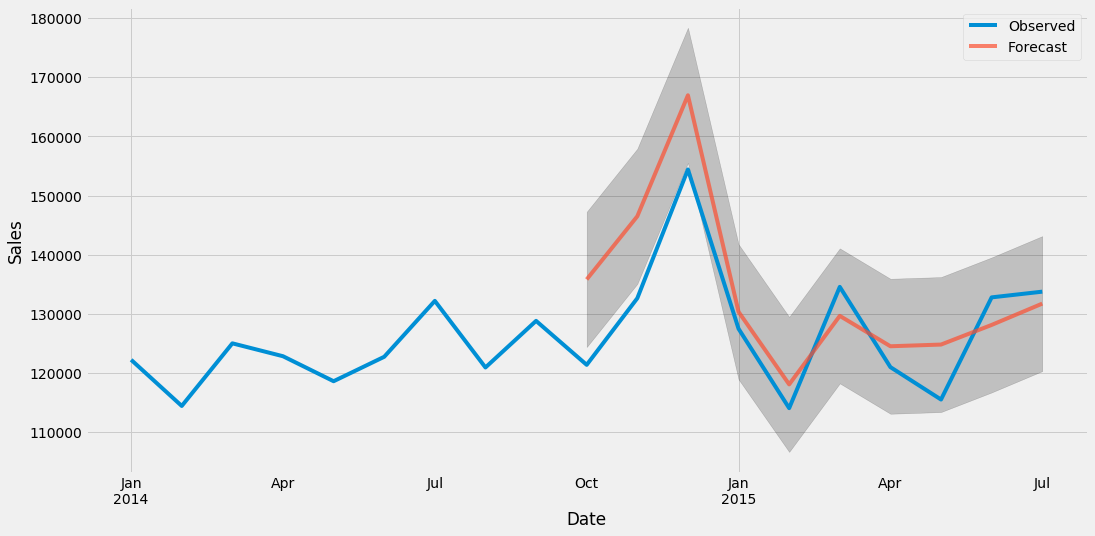

In [46]:
pred = results.get_prediction(start='2014-10-31', dynamic=False)
pred_ci = pred.conf_int()

ax = sales_a['2014':].plot(label='Observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(16,8))
ax.fill_between(pred_ci.index,
pred_ci.iloc[:, 0],
pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

In [55]:
sales_a_forecasted = pred.predicted_mean
sales_a_truth = sales_a['2014-10-31':]

# Compute the mean square error
rmse = np.sqrt(sum((sales_a_forecasted-sales_a_truth)**2)/len(sales_a_forecasted))
print('The Root Mean Square Error (RMSE) of the forcast {}'.format(round(rmse, 2)))

The Root Mean Square Error (RMSE) of the forcast 8545.35
